## Miscellaneous Imports

In [2]:
import pandas as pd
import numpy as np

# Truncate Data

In [ ]:
def truncate(df: pd.DataFrame, target_col: str, n: int) -> pd.DataFrame:
    return df.groupby(target_col).apply(lambda x: x.sample(n=n//2)).droplevel(0)

def df_to_csv(df:pd.DataFrame, path:str):
    import csv
    df.to_csv(path, index=False, quoting=csv.QUOTE_NONNUMERIC)

# df = pd.read_csv('datasets/steam_dataset.csv')
# df = truncate(df, 'review_score', 50000)
# df_to_csv(df, 'datasets/steam_dataset_50000.csv')

/tmp/ipykernel_7892/3415385806.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col).apply(lambda x: x.sample(n=n//2)).droplevel(0)


# Clean Data

In [ ]:
def read_data_from_csv(file_path, column_text, column_score):
    """
    Read data from csv file. Select only the columns that are needed.

    Args:
    file_path: string
    column_text: string
    column_score: string
    """
    data = pd.read_csv(file_path)

    data[column_text] = (
        data[column_text]
        .fillna("")
        .astype(str)
        .apply(lambda x: x.encode("ascii", "ignore").decode("ascii", "ignore"))
    )

    data[column_score] = data[column_score].astype(int)
    return data


def clean_data(data, column_text, column_score, new_column_text='text', new_column_score='score'):
    """
    Clean data: Preprocess text and remove rows with missing values. Change column names.

    Args:
    data: pandas dataframe
    column_text: string
    column_score: string
    new_column_text: string
    new_column_score: string
    """

    data = data.dropna()
    data = data[[column_text, column_score]]
    data = data.rename(columns={column_text: new_column_text, column_score: new_column_score})
    return data

# df = read_data_from_csv('datasets/steam_dataset_50000.csv', 'review_text', 'review_score')
# df = clean_data(df, 'review_text', 'review_score')
# df_to_csv(df, 'datasets/steam_50000_cleaned.csv')

In [6]:
print(df['text'].isna().sum())
print(df['score'].isna().sum())
print(df['text'].map(type).value_counts())

0
0
text
<class 'str'>    48255
Name: count, dtype: int64


# Exploratory Data Analysis

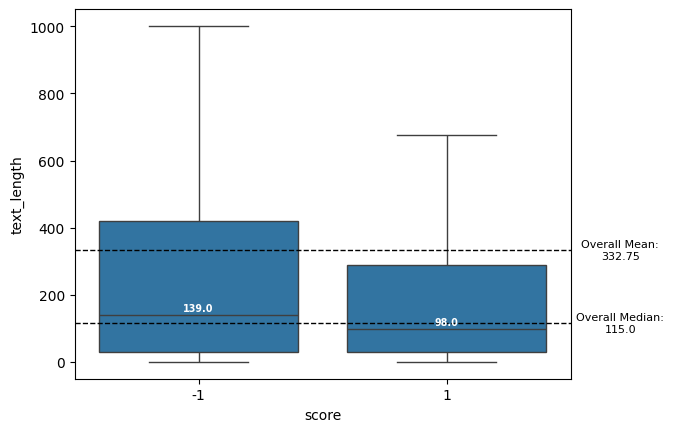

In [44]:
def generate_length_boxplot(df_stemmed: pd.DataFrame, col_text: str, col_score: str):

    from matplotlib import pyplot as plt
    import seaborn as sns

    df_stemmed['text_length'] = df_stemmed[col_text].apply(len)
    box_plot = sns.boxplot(data=df_stemmed, x=col_score, y='text_length', showfliers=False)

    medians = df_stemmed.groupby([col_score])['text_length'].median()
    vertical_offset = df_stemmed['text_length'].median() * 0.1

    for score in (-1, 1):
        box_plot.text(int(score>0), medians[score] + vertical_offset, medians[score],
                      horizontalalignment='center',size='x-small',color='w',weight='semibold')

    overall_median = df_stemmed['text_length'].median()
    box_plot.axhline(overall_median, color='black', linestyle='--', lw=1)
    plt.text(1.7, overall_median, f'Overall Median:\n{overall_median}', horizontalalignment='center', verticalalignment='center', fontsize=8)

    overall_mean = round(df_stemmed['text_length'].mean(), 2)
    box_plot.axhline(overall_mean, color='black', linestyle='--', lw=1)
    plt.text(1.7, overall_mean, f'Overall Mean:\n{overall_mean}', horizontalalignment='center', verticalalignment='center', fontsize=8)

    plt.show()

df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

df['text_length'] = df['text'].str.split().apply(len)
generate_length_boxplot(df, 'text', 'score')

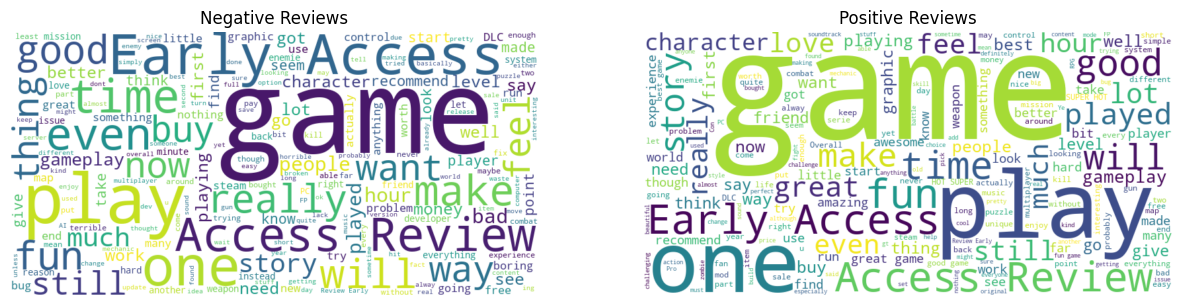

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def generate_wordcloud_freq(df: pd.DataFrame, text_col: str, score_col: str):
    pos_text = " ".join(df[df[score_col] == 1][text_col].astype(str))
    neg_text = " ".join(df[df[score_col] != 1][text_col].astype(str))

    pos_wc = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
    neg_wc = WordCloud(width=800, height=400, background_color='white').generate(neg_text)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(neg_wc, interpolation='bilinear')
    plt.title('Negative Reviews')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pos_wc, interpolation='bilinear')
    plt.title('Positive Reviews')
    plt.axis('off')

    plt.show()


df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

generate_wordcloud_freq(df, 'text', 'score')

# helper functions

In [9]:
def split_data(data, column_score, test_size=0.2, random_state=42):

    from sklearn.model_selection import train_test_split
    
    """
    Split data into training and testing sets

    Args:
    data: pandas dataframe
    column_score: string
    test_size: float
    """
    X = data.drop(columns=[column_score])
    y = data[column_score]
    y = y.replace(-1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_train, X_test, y_train, y_test

final_df = pd.read_csv('datasets/steam_50000_cleaned.csv')
X_train, X_test, y_train, y_test = split_data(final_df, 'score')

In [10]:
def metrics(y_test_np, y_pred):
    from matplotlib import pyplot as plt
    from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score

    f1_score = lambda precision, recall: 2 / (1/precision + 1/recall)
    precision, recall, thresholds = precision_recall_curve(y_test_np, y_pred)
    max_f1 = 0
    best_threshold = 0
    best_recall = 0
    best_precision = 0
    for i in range(len(thresholds)):
        if f1_score(precision[i], recall[i]) > max_f1:
            max_f1 = f1_score(precision[i], recall[i])
            best_recall = recall[i]
            best_precision = precision[i]
            best_threshold = thresholds[i]

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, label='PRC curve')
    plt.plot(best_recall, best_precision, marker = "x", color = "red", ms = 12, label = f"Best Threshold: {best_threshold}\nMax F1 Score: {max_f1}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    return average_precision_score(y_test_np, y_pred), accuracy_score(y_test_np, y_pred > best_threshold), best_threshold, max_f1

def evaluate_deep_learning_model(model, X_test_np, y_test_np):
    """
    Evaluate deep learning model
    """
    y_pred = model.predict(X_test_np).ravel()

    return metrics(y_test_np, y_pred)

# Baseline model

In [ ]:
# pip install transformers torch

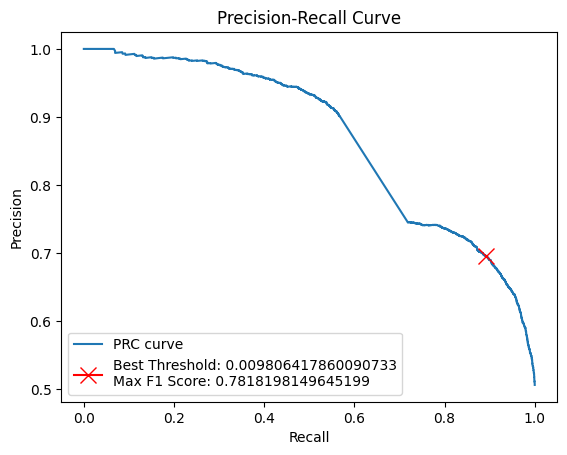

Average precision: 0.8580
Best threshold: 0.0098
Accuracy at best threshold: 0.7477
Max F1: 0.7818


In [13]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def normalize_text(x):
    if isinstance(x, str):
        return x
    if isinstance(x, (list, tuple)):
        return " ".join(map(str, x))
    if pd.isna(x):
        return ""
    return str(x)

def bert_predict_proba(texts, batch_size=32, max_length=128):
    """
    Get probability of POSITIVE class for a list of texts
    using a pre-finetuned BERT model (no tuning).
    """
    all_probs = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        encodings = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        encodings = {k: v.to(device) for k, v in encodings.items()}

        with torch.no_grad():
            outputs = model(**encodings)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            pos_probs = probs[:, 1]

        all_probs.extend(pos_probs.cpu().numpy())

    return np.array(all_probs)

final_df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

X_train, X_test, y_train, y_test = split_data(final_df, 'score')

texts_test = X_test["text"].tolist()
y_test_np = y_test.values

y_pred_proba = bert_predict_proba(texts_test, batch_size=32)

ap, acc, best_th, max_f1 = metrics(y_test_np, y_pred_proba)

print(f"Average precision: {ap:.4f}")
print(f"Best threshold: {best_th:.4f}")
print(f"Accuracy at best threshold: {acc:.4f}")
print(f"Max F1: {max_f1:.4f}")

In [ ]:
# pip install -q vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [8]:
def process_csv_vader(df):
    
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    # Initialize the SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()

    # Initialize lists to store data
    review_texts = []
    positive_scores = []
    negative_scores = []
    neutral_scores = []
    compound_scores = []

    # Perform sentiment analysis and store scores in lists
    for review in df['review_text']:
        review = str(review)
        vs = analyzer.polarity_scores(review)

        review_texts.append(review)
        pos, neg, neu = vs['pos'], vs['neg'], vs['neu']
        positive_scores.append(pos)
        negative_scores.append(neg)
        neutral_scores.append(neu)
        compound_scores.append(((pos - neg) + 1) / 2)

    # Add sentiment scores and NPS categories to the DataFrame

    result_df = df.copy()

    result_df['positive_scores'] = positive_scores
    result_df['negative_scores'] = negative_scores
    result_df['neutral_scores'] = neutral_scores
    result_df['compound_scores'] = compound_scores

    return(result_df)

df = pd.read_csv('datasets/steam_dataset_50000.csv')
df = truncate(df, 'review_score', 2000)
vader_df = process_csv_vader(df)
df_to_csv(vader_df, 'datasets/steam_vader.csv')

C:\Users\DELL\AppData\Local\Temp\ipykernel_46768\2331639530.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col).apply(lambda x: x.sample(n=n//2)).droplevel(0)


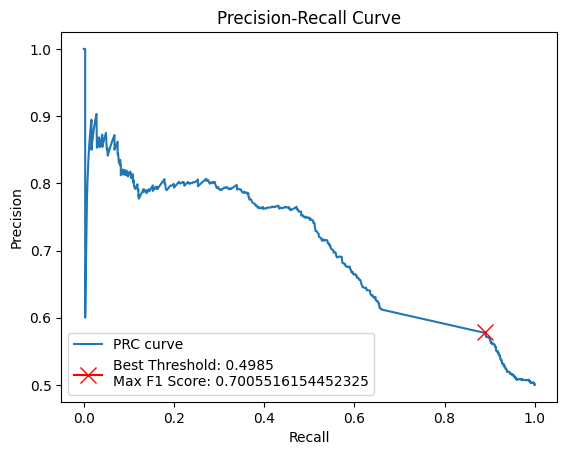

(np.float64(0.6991573059167995),
 0.62,
 np.float64(0.4985),
 np.float64(0.7005516154452325))

In [9]:
vader_df = pd.read_csv('datasets/steam_vader.csv')
metrics(vader_df['review_score'].replace(-1, 0).to_numpy(), vader_df['compound_scores'].to_numpy())

# Fine-tuned model

Using device: cpu
Epoch 1/2 - Training loss: 0.3892
Epoch 2/2 - Training loss: 0.2912


/tmp/ipykernel_7892/1719394568.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  f1_score = lambda precision, recall: 2 / (1/precision + 1/recall)


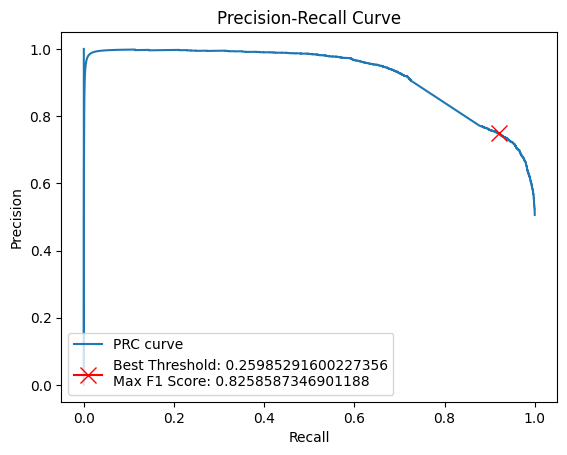

=== DistilBERT full fine-tune on Steam ===
Average precision: 0.9171
Best threshold:    0.2599
Accuracy @ best t: 0.8036
Max F1:            0.8259


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
from matplotlib import pyplot as plt

final_df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

final_df['text'] = final_df['text'].fillna("").astype(str)
final_df['score'] = final_df['score'].astype(int)

X_train_df, X_test_df, y_train, y_test = split_data(final_df, 'score')

texts_train = X_train_df['text'].tolist()
texts_test  = X_test_df['text'].tolist()
y_train_np  = y_train.values.astype(int)
y_test_np   = y_test.values.astype(int)

num_labels = 2


MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = TextDataset(texts_train, y_train_np, tokenizer)
test_dataset  = TextDataset(texts_test,  y_test_np, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Training loss: {avg_loss:.4f}")

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].cpu().numpy()
        all_labels.extend(labels)

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)[:, 1]
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

ap, acc, best_th, max_f1 = metrics(all_labels, all_probs)

print("=== DistilBERT full fine-tune on Steam ===")
print(f"Average precision: {ap:.4f}")
print(f"Best threshold:    {best_th:.4f}")
print(f"Accuracy @ best t: {acc:.4f}")
print(f"Max F1:            {max_f1:.4f}")


Using device: cpu
Epoch 1/3 - Training loss: 0.4490
Epoch 2/3 - Training loss: 0.4356
Epoch 3/3 - Training loss: 0.4303


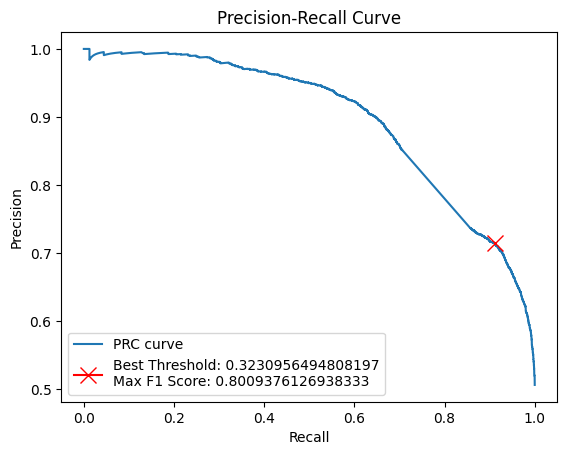

=== DistilBERT head-only fine-tune on Steam ===
Average precision: 0.8876
Best threshold:    0.3231
Accuracy @ best t: 0.7706
Max F1:            0.8009


In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
from matplotlib import pyplot as plt

final_df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

final_df['text'] = final_df['text'].fillna("").astype(str)
final_df['score'] = final_df['score'].astype(int)

X_train_df, X_test_df, y_train, y_test = split_data(final_df, 'score')

texts_train = X_train_df['text'].tolist()
texts_test  = X_test_df['text'].tolist()
y_train_np  = y_train.values.astype(int)
y_test_np   = y_test.values.astype(int)

num_labels = 2

MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = TextDataset(texts_train, y_train_np, tokenizer)
test_dataset  = TextDataset(texts_test,  y_test_np, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)
model.to(device)

for param in model.distilbert.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-4
)

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Training loss: {avg_loss:.4f}")

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].cpu().numpy()
        all_labels.extend(labels)

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)[:, 1]
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

ap, acc, best_th, max_f1 = metrics(all_labels, all_probs)

print("=== DistilBERT head-only fine-tune on Steam ===")
print(f"Average precision: {ap:.4f}")
print(f"Best threshold:    {best_th:.4f}")
print(f"Accuracy @ best t: {acc:.4f}")
print(f"Max F1:            {max_f1:.4f}")

Using device: cpu
trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925
None
[LoRA] Epoch 1/3 - Training loss: 0.4234
[LoRA] Epoch 2/3 - Training loss: 0.3907
[LoRA] Epoch 3/3 - Training loss: 0.3827


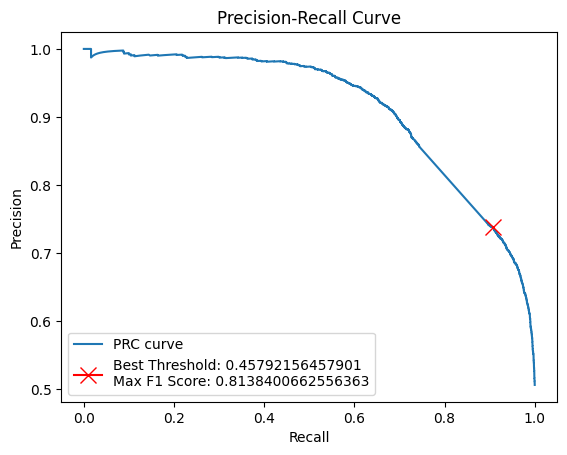

=== DistilBERT LoRA fine-tune on Steam ===
Average precision: 0.9051
Best threshold:    0.4579
Accuracy @ best t: 0.7898
Max F1:            0.8138


In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
from matplotlib import pyplot as plt

from peft import LoraConfig, get_peft_model, TaskType


final_df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

final_df['text'] = final_df['text'].fillna("").astype(str)
final_df['score'] = final_df['score'].astype(int)

X_train_df, X_test_df, y_train, y_test = split_data(final_df, 'score')

texts_train = X_train_df['text'].tolist()
texts_test  = X_test_df['text'].tolist()
y_train_np  = y_train.values.astype(int)
y_test_np   = y_test.values.astype(int)

num_labels = 2

MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = TextDataset(texts_train, y_train_np, tokenizer)
test_dataset  = TextDataset(texts_test,  y_test_np, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_lin", "v_lin"]
)

model = get_peft_model(base_model, lora_config)
model.to(device)

print(model.print_trainable_parameters())

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[LoRA] Epoch {epoch+1}/{num_epochs} - Training loss: {avg_loss:.4f}")

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].cpu().numpy()
        all_labels.extend(labels)

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)[:, 1]
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

ap, acc, best_th, max_f1 = metrics(all_labels, all_probs)

print("=== DistilBERT LoRA fine-tune on Steam ===")
print(f"Average precision: {ap:.4f}")
print(f"Best threshold:    {best_th:.4f}")
print(f"Accuracy @ best t: {acc:.4f}")
print(f"Max F1:            {max_f1:.4f}")


2025-11-06 11:21:19.990571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


2025-11-06 11:21:23.379691: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5695 - loss: 1.2585 - pr_auc: 0.5741
Epoch 1: val_pr_auc improved from None to 0.85977, saving model to model/attention_length.keras
602/602 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.6411 - loss: 0.8020 - pr_auc: 0.6847 - val_accuracy: 0.7612 - val_loss: 0.4879 - val_pr_auc: 0.8598
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7720 - loss: 0.4553 - pr_auc: 0.8744
Epoch 2: val_pr_auc improved from 0.85977 to 0.87501, saving model to model/attention_length.keras
602/602 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - accuracy: 0.7770 - loss: 0.4448 - pr_auc: 0.8804 - val_accuracy: 0.7708 - val_loss: 0.4596 - val_pr_auc: 0.8750
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8162 - loss: 0.3670 - pr_auc: 0.9190
Epoch 3: val_pr_auc did not improve from 0.87501
602/602 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - accuracy: 0.8138 - loss: 0.3732 - pr_auc: 0.9165 - val_accuracy: 0.7736 - val_loss: 0.4665

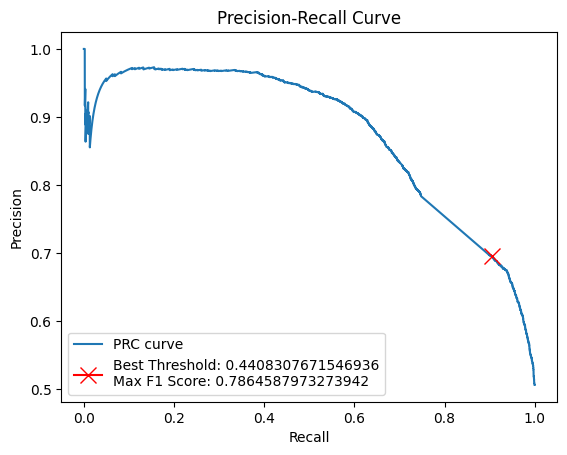

=== Attention + Length model on cleaned data ===
Average precision: 0.8688
Best threshold:    0.4408
Accuracy @ best t: 0.7510
Max F1:            0.7865


In [25]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Input, Attention, Concatenate, Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score

def generate_attention_length_model(X_train, X_test, y_train, y_test,
                                    Length_train, Length_test, save_path, tokenizer,
                                    learning_rate=0.001, embedding_dim=100,
                                    units=100, batch_size=64, epochs=100, patience=3):

    vocab_size = len(tokenizer.word_index) + 1

    input_layer_text = Input(shape=(X_train.shape[1],), name="text_input")

    input_layer_length = Input(shape=(1,), name="length_input")

    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                name="embedding")(input_layer_text)

    lstm_layer = LSTM(units, return_sequences=True, name="lstm_1")(embedding_layer)

    attention = Attention(name="self_attention")([lstm_layer, lstm_layer])

    merged = Concatenate(axis=-1, name="concat_lstm_attn")([lstm_layer, attention])

    merged = LSTM(64, name="lstm_2")(merged)

    concatenated = Concatenate(name="concat_with_length")([merged, input_layer_length])

    output_layer = Dense(1, activation='sigmoid', name="output")(concatenated)

    model = Model(inputs=[input_layer_text, input_layer_length], outputs=output_layer)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[AUC(curve="PR", name="pr_auc"), 'accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_pr_auc',
        patience=patience,
        mode='max',
        restore_best_weights=True
    )

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    model_save = ModelCheckpoint(
        save_path,
        save_best_only=True,
        monitor='val_pr_auc',
        mode='max',
        verbose=1
    )

    model.fit(
        [X_train, Length_train], y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_test, Length_test], y_test),
        callbacks=[early_stopping, model_save],
        verbose=1
    )

    return model

df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

df['text'] = df['text'].fillna("").astype(str)
df['score'] = df['score'].astype(int)

X_train_df, X_test_df, y_train_s, y_test_s = split_data(df, 'score')

texts_train = X_train_df['text'].tolist()
texts_test  = X_test_df['text'].tolist()
y_train = y_train_s.values.astype('float32')
y_test  = y_test_s.values.astype('float32')

max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_train)

seq_train = tokenizer.texts_to_sequences(texts_train)
seq_test  = tokenizer.texts_to_sequences(texts_test)

len_train = np.array([len(seq) for seq in seq_train], dtype='float32')
len_test  = np.array([len(seq) for seq in seq_test], dtype='float32')

Length_train = len_train.reshape(-1, 1)
Length_test  = len_test.reshape(-1, 1)

X_train = pad_sequences(seq_train, maxlen=max_len, padding='post', truncating='post')
X_test  = pad_sequences(seq_test,  maxlen=max_len, padding='post', truncating='post')

save_path = 'model/attention_length.keras'

attn_len_model = generate_attention_length_model(
    X_train, X_test,
    y_train, y_test,
    Length_train, Length_test,
    save_path,
    tokenizer,
    learning_rate=0.001,
    embedding_dim=100,
    units=100,
    batch_size=64,
    epochs=10,
    patience=3
)

y_pred_probs = attn_len_model.predict([X_test, Length_test]).ravel()
ap, acc, best_th, max_f1 = metrics(y_test, y_pred_probs)

print("=== Attention + Length model on cleaned data ===")
print(f"Average precision: {ap:.4f}")
print(f"Best threshold:    {best_th:.4f}")
print(f"Accuracy @ best t: {acc:.4f}")
print(f"Max F1:            {max_f1:.4f}")